This is a supplementary sage notebook for the paper "Extremal quasimodular forms and modular form inequalities for optimal sphere packing". This code checks the modular form identities appearing in the paper.

# Level 1 quasimodular forms

Quasimodular forms of level 1 (or more generally, level $\Gamma_0(N)$ or $\Gamma_1(N)$) is implemented in Sage, mostly by David Ayotte. We define some utility functions that help us to study the quasimodular forms easily.

In [1]:
# Level 1 quasimodular forms
QM = QuasiModularForms(1)
E2, E4, E6 = QM.0, QM.1, QM.2  # generators, normalized as constant terms = 1
disc = (1 / 1728) * (E4^3 - E6^2)  # discriminant form


# Depth
def qm_depth(qm):
    return qm.polynomial().degree(E2.polynomial())

# Fourier coefficients
def qm_coefficients(qm, prec=20):
    qexp = qm.q_expansion(prec)
    return q_expansion_to_list(qexp, prec)

def q_expansion_to_list(qexp, prec=20):
    return [qexp[i] for i in range(prec)]

# Iterative differentiation of quasimodular forms
def dfold(qm, k):
    if k == 0:
        return qm
    else:
        return dfold(qm.derivative(), k - 1)

# Serre derivative with given weight
def qm_serre_der_weight(qm, k=None):
    if k is None:
        k = qm.weight() - qm_depth(qm)
    return qm.derivative() - E2 * qm * (k / 12)

# Dimension of the space of (genuine) modular forms of weight w and level 1
def dim_m(w):
    assert w % 2 == 0
    if w % 12 == 2:
        return w // 12
    else:
        return w // 12 + 1

# Dimension of the space of (genuine) modular forms of weight w, depth <= s and level 1
def dim_qm(w, s):
    assert w % 2 == 0
    assert s >= 0
    d = (w * (s + 1)) // 12
    d -= ((s + 1) // 6) * (s - 3 * ((s + 1) // 6) - 1)
    d += s // 6 + 1
    if (w * (s + 1)) % 12 == 2:
        d -= 1
    return d

# Basis of the space of quasimodular forms of given weight and depth, in terms of Eisenstein series
def qm_basis(w, s):
    basis = []
    for r in range(s + 1):
        w_ = w - 2 * r
        for i in range(w_ // 4 + 1):
            if (w_ - 4 * i) % 6 == 0:
                j = (w_ - 4 * i) // 6
                basis.append(E2^r * E4^i * E6^j)
    return basis

# Vanishing order at the cusp
def qm_cusp_order(qm):
    N = 1000
    c_ = qm_coefficients(qm, N)
    r = 0
    for i in range(N):
        if c_[i] != 0:
            break
        r += 1
    return r

# First nonzero Fourier coefficient
def qm_first_nonzero_coeff(qm):
    N = 1000
    c_ = qm_coefficients(qm, N)
    for i in range(N):
        if c_[i] != 0:
            return c_[i]

# Normalize to make the first nonzero coefficient as 1
def qm_normalize(qm):
    return qm / qm_first_nonzero_coeff(qm)

# Print q-expansion, weight, depth, cusp order, and its polynomial form
def print_qm(qm, name, prec=20):
    print(name + "\n")
    print("q_expansion", qm.q_expansion(prec), "\n")
    print("weight", qm.weight())
    print("depth", qm_depth(qm))
    print("cusp order", qm_cusp_order(qm))
    print("polynomial", qm.polynomial().factor(), "\n")

For example, the following quasimodular forms appear as a part of the magic functions.

In [2]:
F_8d = (E2 * E4 - E6)^2
print_qm(F_8d, "F_8d")

F_24d = 49 * E2^2 * E4^3 - 25 * E2^2 * E6^2 - 48 * E2 * E4^2 * E6 - 25 * E4^4 + 49 * E4 * E6^2
print_qm(F_24d, "F_24d")

F_8d

q_expansion 518400*q^2 + 18662400*q^3 + 255052800*q^4 + 1870387200*q^5 + 9760435200*q^6 + 38755584000*q^7 + 129782476800*q^8 + 372202905600*q^9 + 967623667200*q^10 + 2263116672000*q^11 + 4995028684800*q^12 + 10180874188800*q^13 + 19989201254400*q^14 + 36921804134400*q^15 + 66489204326400*q^16 + 113850991411200*q^17 + 191997786758400*q^18 + 309769955251200*q^19 + O(q^20) 

weight 12
depth 2
cusp order 2
polynomial (-E2*E4 + E6)^2 

F_24d

q_expansion 3657830400*q^3 + 138997555200*q^4 + 2567796940800*q^5 + 27477621964800*q^6 + 203324160614400*q^7 + 1155903669043200*q^8 + 5339174090342400*q^9 + 21015084264652800*q^10 + 72521005100544000*q^11 + 224861553797529600*q^12 + 636227181370368000*q^13 + 1668067755850137600*q^14 + 4088240185030041600*q^15 + 9465006273911193600*q^16 + 20805434866660147200*q^17 + 43762572956919398400*q^18 + 88336945205133004800*q^19 + O(q^20) 

weight 16
depth 2
cusp order 3
polynomial 49*E2^2*E4^3 - 25*E2^2*E6^2 - 48*E2*E4^2*E6 - 25*E4^4 + 49*E4*E6^2 



For a given quasimodular form $F$ and a list of other forms $F_i$, the following function tries to express a linear expression $F = \sum_i c_i F_i$ using the first few Fourier coefficients.

In [3]:
def qm_find_lin_comb(qm, ls):
    w = qm.weight()
    s = qm_depth(qm)
    N = dim_qm(w, s)
    m = matrix([qm_coefficients(qm_, N) for qm_ in ls])
    c_ = vector(qm_coefficients(qm, N))
    x_ = m.solve_left(c_)
    r = sum(x_[j] * ls[j] for j in range(len(ls)))
    assert qm == r
    return x_

For example, the following code shows the identity $E_{10}' = \frac{5}{3}E_{4} E_{6}' + 576\Delta$.

In [4]:
E10 = E4 * E6
print_qm(E10.derivative(), "E_10'")
print(qm_find_lin_comb(E10.derivative(), [E4 * E6.derivative(), disc]))

E_10'

q_expansion -264*q - 270864*q^2 - 15589728*q^3 - 277365792*q^4 - 2578126320*q^5 - 15995060928*q^6 - 74573467584*q^7 - 284022573120*q^8 - 920557851048*q^9 - 2645157604320*q^10 - 6847480097568*q^11 - 16379004749184*q^12 - 36394641851568*q^13 - 76512377741184*q^14 - 152243515448640*q^15 - 290839114879104*q^16 - 532222389723024*q^17 - 944492355175248*q^18 - 1618601492064480*q^19 + O(q^20) 

weight 12
depth 1
cusp order 1
polynomial (-1/6) * (-5*E2*E4*E6 + 3*E4^3 + 2*E6^2) 

(5/3, 576)


We also have a function to plot a quasimodular form on the imaginary axis, i.e. the function $t \mapsto F(it)$.

In [5]:
def qm_to_func(qm, prec=100):
    t = var('t')
    c = qm.q_expansion(prec).list()
    func = c[0]
    for i in range(1, prec):
        func += c[i] * exp(-i * 2 * pi * t)
    return func

def plot_imag_axis(qm_ls, prec=100, low_t=1, high_t=2, names=None):
    # plot qm(it) for a given list of quasimodular forms qm, low_t <= t <= high_t
    # use the first prec terms (0 to prec-1) of q_expansion
    plots = []
    if names is None:
        names = list(range(len(qm_ls)))
    colors = rainbow(len(qm_ls))
    for j, qm in enumerate(qm_ls):
        c = qm_coefficients(qm, prec)
        t = var('t')
        f = c[0]
        for i in range(1, prec):
            f += c[i] * exp(-i * (2 * pi) * t)
        plots.append(
            plot(
                f,
                (t, low_t, high_t),
                axes_labels=['$t$',''],
                legend_label=names[j],
                show_legend=True,
                color=colors[j]
            )
        )
    show(sum(plots))

As an example, here is a plot of all the terms appearing in the definition of `F_24d`.

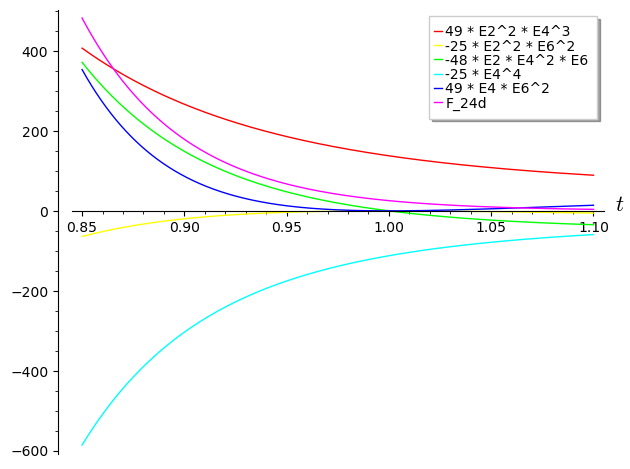

In [6]:
F_24d = 49 * E2^2 * E4^3 - 25 * E2^2 * E6^2 - 48 * E2 * E4^2 * E6 - 25 * E4^4 + 49 * E4 * E6^2
C1 = 49 * E2^2 * E4^3
C2 = - 25 * E2^2 * E6^2
C3 = - 48 * E2 * E4^2 * E6
C4 = - 25 * E4^4
C5 = 49 * E4 * E6^2

ls = [C1, C2, C3, C4, C5, F_24d]
names = ["49 * E2^2 * E4^3", "-25 * E2^2 * E6^2", "-48 * E2 * E4^2 * E6", "-25 * E4^4", "49 * E4 * E6^2", "F_24d"]
plot_imag_axis(ls, low_t=0.85, high_t=1.1, names=names)

# Level 2 quasimodular forms

Level $\Gamma(2)$ quasimodular forms can be written as polynomial in $E_2$, $H_2 = \Theta_2^4$, $H_4 = \Theta_4^4$, where $\Theta_2$ and $\Theta_4$ are Jacobi thetanulle functions. We implement the ring of quasimodular forms of level $\Gamma(2)$ using this fact.

In [7]:
# E2_, E4_, E6_ are the usual Eisenstein series of level 1 and weight 2, 4, 6, but in the space of level 2 forms
QM2.<H2, H4, E2_> = QQ['H2,H4,E2_']
E4_ = H2^2 + H2 * H4 + H4^2
E6_ = (H2 + 2 * H4) * (2 * H2 + H4) * (H4 - H2) / 2
Disc = H2^2 * (H2 + H4)^2 * H4^2 / 256


# Weight
def qm2_weight(qm):
    w = None
    for (a, b, e) in qm.dict().keys():
        if w is None:
            w = 2 * a + 2 * b + 2 * e
        else:
            assert w == 2 * a + 2 * b + 2 * e
    return w

# Depth
def qm2_depth(qm):
    dp = 0
    for (_, _, e) in qm.dict().keys():
        dp = max(e, dp)
    return dp

# Derivative of level 2 quasimodular form
def qm2_derivative(qm):
    r = QM2(0)
    for (a, b, e), coeff in qm.dict().items():
        r += (coeff / 6) * H2^a * H4^b * ((a - 2 * b) * H2 + (2 * a - b) * H4 + (a + b) * E2_) * E2_^e
        if e >= 1:
            r += coeff * H2^a * H4^b * e * E2_^(e-1) * (E2_^2 - E4_) / 12
    return r

def qm2_serre_derivative(qm, k=None):
    s = qm2_depth(qm)
    if k is None:
        # Serre derivative that preserves depth
        k = qm2_weight(qm) - qm2_depth(qm)
    return qm2_derivative(qm) - (k / 12) * E2_ * qm

Level $\Gamma(2)$ quasimodular forms admit expansions in $q^{1/2}$ in general. The below functions give you an expansion in $q^{1/2}$, where the variable's name is `qh`.

In [8]:
# q-series
# Note that the variable `q` in the expansion is in fact e^(pi * i * z), which is `q^(1/2)`.
# The default precision is fixed (which is enough for our purpose), but you can increase it
prec = 80
qh = var('qh')  # q^1/2

def sigma(k, m):
    r = 0
    for i in range(1, k + 1):
        if k%i == 0:
            r += i^m
    return r

def r4(k):
    if k == 0:
        return 1
    elif k % 4 == 0:
        return 8 * sigma(k, 1) - 32 * sigma(k / 4, 1)
    else:
        return 8 * sigma(k, 1)

# q-series of Jacobi thetanulle functions
H3ser = 1
for i in range(1, prec):
    H3ser += r4(i) * qh^i
H4ser = 1
for i in range(1, prec):
    H4ser += (-1)^i * r4(i) * qh^i
H2ser = H3ser - H4ser

# q-series of Eisenstein series
E2ser = 1
for i in range(1, prec):
    E2ser -= 24 * sigma(i, 1) * qh^(2 * i)

E4ser = 1
for i in range(1, prec):
    E4ser += 240 * sigma(i, 3) * qh^(2 * i)
    
E6ser = 1
for i in range(1, prec):
    E6ser -= 504 * sigma(i, 5) * qh^(2 * i)

def qm2_q_series(qm, prec=20):
    # Recall that the series is in q^(1/2)
    r = 0
    H2ser_ = H2ser.series(qh, prec)
    H4ser_ = H4ser.series(qh, prec)
    E2ser_ = E2ser.series(qh, prec)
    for (a, b, e), coeff in qm.dict().items():
        r += coeff * H2ser_^a * H4ser_^b * E2ser_^e
    return r.series(qh, prec)

# Cusp order
def qm2_cusp_order(qm):
    N = 50
    c = qm2_q_series(qm, N).list()
    for i in range(N):
        if c[i] != 0:
            return i / 2

# First nonzero Fourier coefficient
def qm2_first_nonzero_coeff(qm):
    N = 100
    c = qm2_q_series(qm, N).list()
    for i in range(N):
        if c[i] != 0:
            return Rational(c[i])

def qm2_normalize(qm):
    return qm / qm2_first_nonzero_coeff(qm)

def print_qm2(qm, name, prec=30):
    print(name + "\n")
    print("q_expansion", qm2_q_series(qm, prec), "\n")
    print("weight", qm2_weight(qm))
    print("depth", qm2_depth(qm))
    print("cusp order", qm2_cusp_order(qm))
    print("polynomial", qm.factor(), "\n")

In [9]:
print_qm2(H2 + H4, "H3")

H3

q_expansion 1 + 8*qh + 24*qh^2 + 32*qh^3 + 24*qh^4 + 48*qh^5 + 96*qh^6 + 64*qh^7 + 24*qh^8 + 104*qh^9 + 144*qh^10 + 96*qh^11 + 96*qh^12 + 112*qh^13 + 192*qh^14 + 192*qh^15 + 24*qh^16 + 144*qh^17 + 312*qh^18 + 160*qh^19 + 144*qh^20 + 256*qh^21 + 288*qh^22 + 192*qh^23 + 96*qh^24 + 248*qh^25 + 336*qh^26 + 320*qh^27 + 192*qh^28 + 240*qh^29 + Order(qh^30) 

weight 2
depth 0
cusp order 0
polynomial H2 + H4 



We can also define `qm2_find_lin_comb` for level $\Gamma(2)$ quasimodular forms.

In [10]:
def m2_basis(w):
    basis = []
    if w == 0:
        return [1]
    for j in range(w // 2 + 1):
        basis.append(H2^j * H4^(w / 2 - j))
    return basis

def dim_m2(w):
    return w / 2 + 1

def qm2_basis(w, s=None):
    basis = []
    if s is None:
        s = w / 2
    for k in range(s + 1):
        mf_basis = m2_basis(w - 2 * k)
        for mf in mf_basis:
            basis.append(E2_^k * mf)
    return basis

def dim_qm2(w, s=None):
    if s is None:
        s = w / 2
    d = 0
    for k in range(s + 1):
        d += dim_m2(w - 2 * k)
    return d

def qm2_find_lin_comb(qm, ls, prec=40):
    w = qm2_weight(qm)
    s = qm2_depth(qm)
    N = dim_qm2(w, s)
    m = matrix([qm2_q_series(qm_, N).list()[:N] for qm_ in ls])
    c_ = vector(qm2_q_series(qm, N).list())
    x_ = m.solve_left(c_)
    # check if we get the right result
    r = sum(Rational(x_[j]) * ls[j] for j in range(len(ls)))
    assert r == qm
    return x_

We can also embed a level $1$ form as a level $\Gamma(2)$ form.

In [11]:
# Rewrite level 1 quasimodular forms as level Gamma(2) forms
def l1_to_l2(qm):
    r = QM2(0)
    for (d2, d4, d6), coeff in qm.polynomial().dict().items():
        r += coeff * E2_^d2 * E4_^d4 * E6_^d6
    return r

In [12]:
assert l1_to_l2(E2) == E2_
assert l1_to_l2(E4) == E4_
assert l1_to_l2(E6) == E6_

The subring of quasimodular forms of level $\Gamma_0(2) \subset \Gamma(2)$ is generated by $A = H_2^2$ and $B = H_2 + 2 H_4$. They are invariant under $z \mapsto z + 1$, so there are no $q^{\text{odd}/2}$ terms appearing in $q$-expansions. Especially, in terms of our variable `q`, only even powers appear. We can compute a basis of the ring of modular forms of level $\Gamma_0(2)$ and the dimensions.

In [13]:
# Generators
A = H2^2
B = H2 + 2 * H4


def gamma02_basis(w):
    basis = []
    if w == 0:
        return [1]
    assert w % 2 == 0
    for j in range(w // 4 + 1):
        basis.append(A^j * B^(w / 2 - 2 * j))
    return basis

def gamma02_dim(w):
    return w // 4 + 1


def qm_gamma02_basis(w, s=None):
    basis = []
    if s is None:
        s = w / 2
    for k in range(s + 1):
        mf_basis = gamma02_basis(w - 2 * k)
        for mf in mf_basis:
            basis.append(E2_^k * mf)
    return basis

def qm_gamma02_dim(w, s=None):
    if s is None:
        s = w / 2
    d = 0
    for k in range(s + 1):
        d += gamma02_dim(w - 2 * k)
    return d

Note that both $A$ and $B$ have nonnegative Fourier coefficients.

In [14]:
print_qm2(A, "A = H_2^2")
print_qm2(B, "B = H_2 + 2 * H_4")

A = H_2^2

q_expansion 256*qh^2 + 2048*qh^4 + 7168*qh^6 + 16384*qh^8 + 32256*qh^10 + 57344*qh^12 + 88064*qh^14 + 131072*qh^16 + 193792*qh^18 + 258048*qh^20 + 340992*qh^22 + 458752*qh^24 + 562688*qh^26 + 704512*qh^28 + Order(qh^30) 

weight 4
depth 0
cusp order 1
polynomial H2^2 

B = H_2 + 2 * H_4

q_expansion 2 + 48*qh^2 + 48*qh^4 + 192*qh^6 + 48*qh^8 + 288*qh^10 + 192*qh^12 + 384*qh^14 + 48*qh^16 + 624*qh^18 + 288*qh^20 + 576*qh^22 + 192*qh^24 + 672*qh^26 + 384*qh^28 + Order(qh^30) 

weight 2
depth 0
cusp order 0
polynomial H2 + 2*H4 



In [15]:
def qm2_to_func(qm, prec=20):
    qser = qm2_q_series(qm, prec=prec)
    c = qser.list()
    t = var('t')
    func = c[0]
    for i in range(1, len(c)):
        func += c[i] * exp(-i * pi * t)  # note q^(1/2) = e^(sqrt(-1) * pi * z)
    return func

def qm2_plot_imag_axis(qm_ls, prec=20, low_t=1, high_t=2, names=None):
    # plot qm(it) for a given quasimodular form qm, low_t <= t <= high_t
    # use the first prec terms (0 to prec-1) of q_expansion
    plots = []
    if names is None:
        names = list(range(len(qm_ls)))
    colors = rainbow(len(qm_ls))
    for j, qm in enumerate(qm_ls):
        ft = negform_to_func(qm, prec=prec)
        plots.append(
            plot(
                ft,
                (t, low_t, high_t),
                axes_labels=['$x$','$y$'],
                legend_label=names[j],
                show_legend=True,
                color=colors[j]
            )
        )
    show(sum(plots))

For a given quasimodular form $f(z)$ of level $1$, $f^{(2)}(z) := f(2z)$ defines a quaismodular form of level $\Gamma_0(2) \subset \Gamma(2)$ (which are called *old forms*).

In [16]:
# Eisenstein series E_2(2z), E_4(2z), and E_6(2z)
E2_2 = (B + 2 * E2_) / 4
E4_2 = B^2 / 4 - 3 * A / 16
E6_2 = B^3 / 8 - 9 * A * B / 64


def double_level(qm):
    # f(z) -> f(2z), from level Gamma(1) to Gamma_0(2)
    r = QM2(0)
    for (d2, d4, d6), coeff in qm.polynomial().dict().items():
        r += coeff * E2_2^d2 * E4_2^d4 * E6_2^d6
    return r

In [17]:
print_qm2(E2_2, "E2(2z)")
print_qm2(E4_2, "E4(2z)")
print_qm2(E6_2, "E6(2z)")

E2(2z)

q_expansion 1 + (-24)*qh^4 + (-72)*qh^8 + (-96)*qh^12 + (-168)*qh^16 + (-144)*qh^20 + (-288)*qh^24 + (-192)*qh^28 + Order(qh^30) 

weight 2
depth 1
cusp order 0
polynomial (1/4) * (H2 + 2*H4 + 2*E2_) 

E4(2z)

q_expansion 1 + 240*qh^4 + 2160*qh^8 + 6720*qh^12 + 17520*qh^16 + 30240*qh^20 + 60480*qh^24 + 82560*qh^28 + Order(qh^30) 

weight 4
depth 0
cusp order 0
polynomial (1/16) * (H2^2 + 16*H2*H4 + 16*H4^2) 

E6(2z)

q_expansion 1 + (-504)*qh^4 + (-16632)*qh^8 + (-122976)*qh^12 + (-532728)*qh^16 + (-1575504)*qh^20 + (-4058208)*qh^24 + (-8471232)*qh^28 + Order(qh^30) 

weight 6
depth 0
cusp order 0
polynomial (-1/64) * (H2 + 2*H4) * (H2^2 - 32*H2*H4 - 32*H4^2) 



In [18]:
# Returns a list of modular components of a given level \Gamma(2) quasimodular form
def qm2_components(qm):
    s = qm2_depth(qm)
    comps = [QM2(0)] * (s + 1)
    for (a, b, e), coeff in qm.dict().items():
        # monomial: coeff * H2^a * H4^b * E2_^e
        comps[e] += coeff * H2^a * H4^b
    return comps

H2_T = -H2
H4_T = H2 + H4  # H3
# Computes T-action of a given modular form of level \Gamma(2).
def m2_T_action(m):
    assert qm2_depth(m) == 0, "Not a genuine modular form."
    r = QM2(0)
    for (a, b, _), coeff in m.dict().items():
        r += coeff * H2_T^a * H4_T^b
    return r

## $d = 8$

For dimension $8$, we have two modular forms $F$ and $G$ correspond to $(+1)$ and $(-1)$ Fourier eigenfunctions.

In [19]:
F_8d = (E2 * E4 - E6)^2
print_qm(F_8d, "F_8d")

G_8d = H2^3 * (2 * H2^2 + 5 * H2 * H4 + 5 * H4^2)
print_qm2(G_8d, "G_8d")

F_8d

q_expansion 518400*q^2 + 18662400*q^3 + 255052800*q^4 + 1870387200*q^5 + 9760435200*q^6 + 38755584000*q^7 + 129782476800*q^8 + 372202905600*q^9 + 967623667200*q^10 + 2263116672000*q^11 + 4995028684800*q^12 + 10180874188800*q^13 + 19989201254400*q^14 + 36921804134400*q^15 + 66489204326400*q^16 + 113850991411200*q^17 + 191997786758400*q^18 + 309769955251200*q^19 + O(q^20) 

weight 12
depth 2
cusp order 2
polynomial (-E2*E4 + E6)^2 

G_8d

q_expansion 20480*qh^3 + 2015232*qh^5 + 41656320*qh^7 + 399933440*qh^9 + 2434068480*qh^11 + 10946396160*qh^13 + 39685644288*qh^15 + 122413547520*qh^17 + 333096652800*qh^19 + 819943505920*qh^21 + 1859254149120*qh^23 + 3937755267072*qh^25 + 7871982018560*qh^27 + 14975122391040*qh^29 + Order(qh^30) 

weight 10
depth 0
cusp order 3/2
polynomial H2^3 * (2*H2^2 + 5*H2*H4 + 5*H4^2) 



The following graph of the quotient $F(it) / G(it)$ suggests us to prove: the function is monotone decreasing, and the limit as $t \to 0^+$ is $18 / \pi^2$.

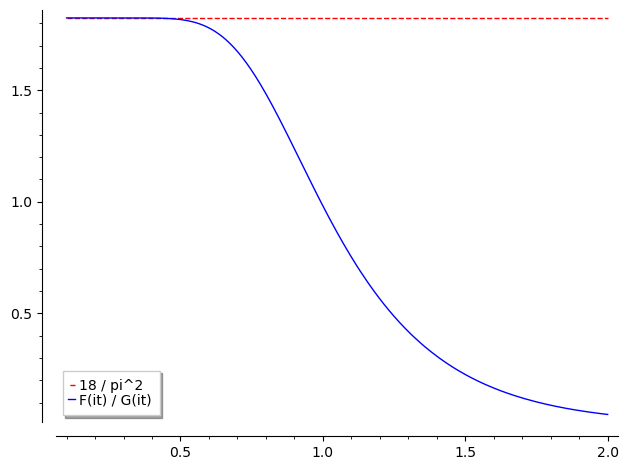

In [20]:
f_8d = qm_to_func(F_8d, prec=50)
g_8d = qm2_to_func(G_8d, prec=100)

q_8d = f_8d / g_8d
lim_8d = 18 / pi^2


p = plot(lim_8d, (t, 0.1, 2.0), color="red", legend_label="18 / pi^2", linestyle="dashed") + \
    plot(q_8d, (t, 0.1, 2.0), color="blue", legend_label="F(it) / G(it)")
show(p)

To prove monotonicity, one needs to prove that $F' G - FG'$ is positive, or equivalently, $(\partial_{10} F) G - F (\partial_{10}G)$ is positive. This factors nicely, and the last term can be shown to be positive as in the paper.

In [21]:
F_8d_ = l1_to_l2(F_8d)
L_8d = qm2_serre_derivative(F_8d_) * G_8d - F_8d_ * qm2_serre_derivative(G_8d) 
print_qm2(L_8d, "L_8d")

# We have two quasimodular factors, which are both positive
# The first factor is nothing but 3 * E4', which has positive Fourier coefficients
Fac_8d_1 = (1/2) * (2*H2^3 + 3*H2^2*H4 - 3*H2*H4^2 - 2*H4^3 + 2*H2^2*E2_ + 2*H2*H4*E2_ + 2*H4^2*E2_)
print_qm2(Fac_8d_1, "First factor: (2*H2^3 + 3*H2^2*H4 - 3*H2*H4^2 - 2*H4^3 + 2*H2^2*E2 + 2*H2*H4*E2 + 2*H4^2*E2) / 2")
assert Fac_8d_1 == E2_ * E4_ - E6_
assert Fac_8d_1 == 3 * qm2_derivative(E4_)

# The second factor is E4 - (H2 + 2 * H4) * E2 / 2
Fac_8d_2 = (-1/2) * (-2*H2^2 - 2*H2*H4 - 2*H4^2 + H2*E2_ + 2*H4*E2_)  # include the negative sign
print_qm2(Fac_8d_2, "Second factor: H2^2 + H2*H4 + H4^2 - (H2 + 2 * H4) * E2 / 2")
assert Fac_8d_2 == E4_ - B * E2_ / 2
assert Fac_8d_2 == E4_ - E2_ * (2 * E2_2 - E2_)
assert Fac_8d_2 == (E4_ - E4_2) + (E4_2 - E2_2^2) + (E2_ - E2_2)^2

L_8d

q_expansion 5308416000*qh^7 + 50960793600*qh^9 + (-528718233600)*qh^11 + (-1961990553600)*qh^13 + 23011983360000*qh^15 + (-22728513945600)*qh^17 + (-168678103449600)*qh^19 + (-25149151641600)*qh^21 + 2255043782246400*qh^23 + (-1339334590464000)*qh^25 + (-14279004153446400)*qh^27 + 15087095827660800*qh^29 + Order(qh^30) 

weight 24
depth 2
cusp order 7/2
polynomial (-15/8) * H4^2 * (H2 + H4)^2 * H2^3 * (-2*H2^2 - 2*H2*H4 - 2*H4^2 + H2*E2_ + 2*H4*E2_) * (2*H2^3 + 3*H2^2*H4 - 3*H2*H4^2 - 2*H4^3 + 2*H2^2*E2_ + 2*H2*H4*E2_ + 2*H4^2*E2_) 

First factor: (2*H2^3 + 3*H2^2*H4 - 3*H2*H4^2 - 2*H4^3 + 2*H2^2*E2 + 2*H2*H4*E2 + 2*H4^2*E2) / 2

q_expansion 720*qh^2 + 12960*qh^4 + 60480*qh^6 + 210240*qh^8 + 453600*qh^10 + 1088640*qh^12 + 1733760*qh^14 + 3369600*qh^16 + 4905360*qh^18 + 8164800*qh^20 + 10549440*qh^22 + 17660160*qh^24 + 20573280*qh^26 + 31207680*qh^28 + Order(qh^30) 

weight 6
depth 1
cusp order 1
polynomial (1/2) * (2*H2^3 + 3*H2^2*H4 - 3*H2*H4^2 - 2*H4^3 + 2*H2^2*E2_ + 2*H2*H4*E2

We can check that each of (the modular components of) the factors have level $\Gamma_0(2)$.

In [22]:
ls_1 = qm2_components(Fac_8d_1)
for m in ls_1:
    assert m2_T_action(m) == m
ls_2 = qm2_components(Fac_8d_2)
for m in ls_2:
    assert m2_T_action(m) == m

# Extremal quasimodular forms

For given $w$ and $s$, **extremal quasimodular form** of weight $w$ and depth $s$ is defined as a quasimodular form with the maximum possible order of vanishing at infinity (Kaneko-Koike, 2003). It is shown that the extremal form is unique up to a constant for $s \leq 4$ (Pellarin, 2020). Also, we have a recursive formula for those extremal forms (Grabner, 2020). Below codes return the normalized extremal quasimodular form of given weight and depth for depth $1$ and $2$ using Grabner's recurrence relation. For depth $\geq 3$, we compute the extremal form naively using the Eisenstein series basis. Note that there are similar but complicated recurrence relations for depth $3$ and $4$ by Grabner, and the (unique) existence of extremal forms in the case of depth $\geq 5$ is still open.

In [23]:
# Use cache
from functools import lru_cache


# Extremal quasimodular forms
def is_extremal_qm(qm):
    # Check if a given quasimodular form is extremal (in the sense of Kaneko-Koike)
    s = qm_depth(qm)
    w = qm.weight()
    d = dim_qm(w, s)
    order = qm_cusp_order(qm)
    return d - 1 == order
    
@lru_cache(maxsize=None)
def _extremal_qm_d1(w):
    if w < 6:
        assert False, "weight should be >= 6"
    if w == 6:
        return (1 / 720) * (E2 * E4 - E6)
    else:
        if w % 6 == 0:
            _qm = _extremal_qm_d1(w - 6)
            res = E4 * qm_serre_der_weight(_qm, w - 7) - ((w - 5) / 12) * E6 * _qm
            res *= w / (72 * (w - 5) * (w - 1))
            assert is_extremal_qm(res), "not extremal"
            return res
        elif w % 6 == 2:
            _qm = _extremal_qm_d1(w - 2)
            res = (12 / (w - 1)) * qm_serre_der_weight(_qm, w - 3)
            assert is_extremal_qm(res), "not extremal"
            return res
        elif w % 6 == 4:
            _qm = _extremal_qm_d1(w - 4)
            res = E4 * _qm
            assert is_extremal_qm(res), "not extremal"
            return res
        else:
            assert False, "weight is odd"
    
@lru_cache(maxsize=None)
def _extremal_qm_d2(w):
    if w < 4:
        assert False, "weight should be >= 4"
    if w == 4:
        return (1 / 288) * (E4 - E2^2)
    elif w % 4 == 0:
        _qm = _extremal_qm_d2(w - 4)
        res = ((w - 3) * (w - 4) / 36) * E4 * _qm
        res -= qm_serre_der_weight(qm_serre_der_weight(_qm, w - 6), w - 4)
        res *= (3 * (w)^2) / (16 * (w - 1) * (w - 2)^2 * (w - 3))
        assert is_extremal_qm(res), "not extremal"
        return res
    elif w % 4 == 2:
        _qm = _extremal_qm_d2(w - 2)
        res = qm_serre_der_weight(_qm, w - 4)
        res *= (6 / (w - 1))
        assert is_extremal_qm(res), "not extremal"
        return res
    else:
        assert False, "weight is odd"

@lru_cache(maxsize=None)
def extremal_qm(weight, depth):
    # Find the extremal qmf (if exists) for given weight and depth
    # The result is normalized so that first nonzero coefficient is 1
    assert (0 <= depth <= weight/2 and 2 * (depth + 1) != weight), "inappropriate weight and depths"
    
    if depth == 1:
        return _extremal_qm_d1(weight)
    if depth == 2:
        return _extremal_qm_d2(weight)

    bs = qmf_basis(weight, depth)
    d = dim_qm(weight, depth)
    m = matrix([coefficients(qm_, d) for qm_ in bs])
    c_ = vector([0] * (d - 1) + [1])
    x_ = m.solve_left(c_)
      
    ans = sum(x_[j] * bs[j] for j in range(d))
    return normalize(ans)

We can *guess* the recursive relations for $X_{w, 1}$ and their derivatives from the below results, which are
$$
\begin{align*}
X_{w, 1}' &= \frac{5w}{72} X_{6, 1} X_{w-4, 1} + \frac{7w}{72} X_{8, 1} X_{w-6, 1} \\
X_{w+2, 1}' &= \frac{5w}{72} X_{6, 1} X_{w-2, 1} + \frac{7w}{72} X_{8, 1} X_{w-4, 1} \\
X_{w+4, 1}' &= 240 X_{6, 1}X_{w, 1} + \frac{7w}{72} X_{8, 1} X_{w-2, 1} + \frac{5w}{72} X_{10, 1} X_{w-4, 1} 
\end{align*}
$$
for $w\equiv 0\,(\mathrm{mod}\,6), w\geq 12$.

In [24]:
X_6_1 = extremal_qm(6, 1)
X_8_1 = extremal_qm(8, 1)
X_10_1 = extremal_qm(10, 1)

# w = 6k
print("w = 6k")
for w in range(12, 61, 6):
    X_wm6_1 = extremal_qm(w-6, 1)
    X_wm4_1 = extremal_qm(w-4, 1)

    X_w_1 = extremal_qm(w, 1)
    dX_w_1 = X_w_1.derivative()
    
    c = qm_find_lin_comb(dX_w_1, [X_6_1 * X_wm4_1, X_8_1 * X_wm6_1])
    print(w, c[0], c[1])
print()

# w = 6k + 2
print("w = 6k + 2")
for w in range(12, 61, 6):
    X_wm2_1 = extremal_qm(w-2, 1)
    X_wm4_1 = extremal_qm(w-4, 1)

    X_wp2_1 = extremal_qm(w+2, 1)
    dX_wp2_1 = X_wp2_1.derivative()
    
    c = qm_find_lin_comb(dX_wp2_1, [X_6_1 * X_wm2_1, X_8_1 * X_wm4_1])
    print(w + 2, c[0], c[1])
print()

# w = 6k + 4
print("w = 6k + 4")
for w in range(12, 61, 6):
    X_w_1 = extremal_qm(w, 1)
    X_wm2_1 = extremal_qm(w-2, 1)
    X_wm4_1 = extremal_qm(w-4, 1)

    X_wp4_1 = extremal_qm(w+4, 1)
    dX_wp4_1 = X_wp4_1.derivative()
    
    c = qm_find_lin_comb(dX_wp4_1, [X_6_1 * X_w_1, X_8_1 * X_wm2_1, X_10_1 * X_wm4_1])
    print(w + 4, c[0], c[1], c[2])

w = 6k
12 2 0
18 5/4 7/4
24 5/3 7/3
30 25/12 35/12
36 5/2 7/2
42 35/12 49/12
48 10/3 14/3
54 15/4 21/4
60 25/6 35/6

w = 6k + 2
14 5/6 7/6
20 5/4 7/4
26 5/3 7/3
32 25/12 35/12
38 5/2 7/2
44 35/12 49/12
50 10/3 14/3
56 15/4 21/4
62 25/6 35/6

w = 6k + 4
16 240 2 0
22 240 7/4 5/4
28 240 7/3 5/3
34 240 35/12 25/12
40 240 7/2 5/2
46 240 49/12 35/12
52 240 14/3 10/3
58 240 21/4 15/4
64 240 35/6 25/6


Here's a list of depth $2$ extremal forms of weight $w \leq 14$.

In [25]:
for w in range(4, 15, 2):
    if w != 6:
        print_qm(extremal_qm(w, 2), "X_" + str(w) + ",2")

X_4,2

q_expansion q + 6*q^2 + 12*q^3 + 28*q^4 + 30*q^5 + 72*q^6 + 56*q^7 + 120*q^8 + 117*q^9 + 180*q^10 + 132*q^11 + 336*q^12 + 182*q^13 + 336*q^14 + 360*q^15 + 496*q^16 + 306*q^17 + 702*q^18 + 380*q^19 + O(q^20) 

weight 4
depth 2
cusp order 1
polynomial (1/288) * (-E2^2 + E4) 

X_8,2

q_expansion q^2 + 16*q^3 + 102*q^4 + 416*q^5 + 1308*q^6 + 3360*q^7 + 7772*q^8 + 15744*q^9 + 30606*q^10 + 53680*q^11 + 93352*q^12 + 148512*q^13 + 238616*q^14 + 354912*q^15 + 537336*q^16 + 757248*q^17 + 1100421*q^18 + 1485648*q^19 + O(q^20) 

weight 8
depth 2
cusp order 2
polynomial (1/362880) * (-7*E2^2*E4 + 2*E2*E6 + 5*E4^2) 

X_10,2

q_expansion q^2 + 104/3*q^3 + 390*q^4 + 2480*q^5 + 11140*q^6 + 39216*q^7 + 117020*q^8 + 303680*q^9 + 717990*q^10 + 1546600*q^11 + 9438728/3*q^12 + 5976048*q^13 + 10941320*q^14 + 18987920*q^15 + 32156280*q^16 + 52106496*q^17 + 83152173*q^18 + 127695960*q^19 + O(q^20) 

weight 10
depth 2
cusp order 2
polynomial (-1/1088640) * (-5*E2^2*E6 - 2*E2*E4^2 + 7*E4*E6) 

X_12,2

q_e

We can prove complete positivity of these by using *exceptional identities*.

In [26]:
X_12_1 = extremal_qm(12, 1)

X_4_2 = extremal_qm(4, 2)
X_8_2 = extremal_qm(8, 2)
X_10_2 = extremal_qm(10, 2)
X_12_2 = extremal_qm(12, 2)
X_14_2 = extremal_qm(14, 2)

# identities
assert X_8_2.derivative() == 2 * X_4_2 * X_6_1
assert X_10_2.derivative() == (8/9) * X_4_2 * X_8_1 + (10/9) * X_6_1^2
assert X_12_2.derivative() == 3 * X_6_1 * X_8_2
assert X_14_2.derivative() == 3 * X_4_2 * X_12_1

Using extremal forms of level $1$, we can construct level $\Gamma_0(2)$ positive with above level-doubling map $f(z) \mapsto f^{(2)}(z) := f(2z)$. Especially, the form $Y_{w, s}:= X_{w, s} - 2^{w-s} X_{w, s}^{(2)}$ is positive for $(w, s) \in \{(6, 1), (4, 2), (8, 2), (10, 2), (12, 2)\}$

In [27]:
def Y(w, s):
    X_w_s = extremal_qm(w, s)
    X_w_s_ = l1_to_l2(X_w_s)
    X_w_s_2 = double_level(X_w_s)
    return X_w_s_ - 2^(w-s) * X_w_s_2

In [28]:
for (w, s) in [(6, 1), (4, 2), (8, 2), (10, 2), (12, 2)]:
    print_qm2(Y(w, s), "Y_" + str(w) + "," + str(s))

Y_6,1

q_expansion 1*qh^2 + (-14)*qh^4 + 84*qh^6 + (-284)*qh^8 + 630*qh^10 + (-1176)*qh^12 + 2408*qh^14 + (-4664)*qh^16 + 6813*qh^18 + (-8820)*qh^20 + 14652*qh^22 + (-23856)*qh^24 + 28574*qh^26 + (-33712)*qh^28 + Order(qh^30) 

weight 6
depth 1
cusp order 1
polynomial (-1/96) * H4 * (-H2 - 2*H4 + 2*E2_) * (H2 + H4) 

Y_4,2

q_expansion 1*qh^2 + 2*qh^4 + 12*qh^6 + 4*qh^8 + 30*qh^10 + 24*qh^12 + 56*qh^14 + 8*qh^16 + 117*qh^18 + 60*qh^20 + 132*qh^22 + 48*qh^24 + 182*qh^26 + 112*qh^28 + Order(qh^30) 

weight 4
depth 1
cusp order 1
polynomial (1/288) * (H2^2 - 2*H2*H4 - 2*H4^2 + H2*E2_ + 2*H4*E2_) 

Y_8,2

q_expansion 1*qh^4 + 16*qh^6 + 38*qh^8 + 416*qh^10 + 284*qh^12 + 3360*qh^14 + 1244*qh^16 + 15744*qh^18 + 3982*qh^20 + 53680*qh^22 + 9640*qh^24 + 148512*qh^26 + 23576*qh^28 + Order(qh^30) 

weight 8
depth 2
cusp order 2
polynomial (1/120960) * (2*H2^4 - 3*H2^3*H4 - 92*H2^2*H4^2 - 178*H2*H4^3 - 89*H4^4 + 2*H2^3*E2_ + 31*H2^2*H4*E2_ + 81*H2*H4^2*E2_ + 54*H4^3*E2_ + 35*H2*H4*E2_^2 + 35*H4^2*E

In [29]:
# identities that proves Y(w, s) > 0
assert X_4_2 == - E2.derivative() / 24
assert X_8_2 == - E6.derivative() / 15120 - dfold(E4, 2) / 7200
assert X_10_2 == (E4^2).derivative() / 60480 + dfold(E6, 2) / 63504

## $d = 24$

The (quasi)modular forms for the $24$-dimensional magic function are following.

In [30]:
F_24d = 49 * E2^2 * E4^3 - 25 * E2^2 * E6^2 - 48 * E2 * E4^2 * E6 - 25 * E4^4 + 49 * E4 * E6^2
print_qm(F_24d, "F_24d")

G_24d = H2^5 * (2 * H2^2 + 7 * H2 * H4 + 7 * H4^2)
print_qm2(G_24d, "G_24d")

F_24d

q_expansion 3657830400*q^3 + 138997555200*q^4 + 2567796940800*q^5 + 27477621964800*q^6 + 203324160614400*q^7 + 1155903669043200*q^8 + 5339174090342400*q^9 + 21015084264652800*q^10 + 72521005100544000*q^11 + 224861553797529600*q^12 + 636227181370368000*q^13 + 1668067755850137600*q^14 + 4088240185030041600*q^15 + 9465006273911193600*q^16 + 20805434866660147200*q^17 + 43762572956919398400*q^18 + 88336945205133004800*q^19 + O(q^20) 

weight 16
depth 2
cusp order 3
polynomial 49*E2^2*E4^3 - 25*E2^2*E6^2 - 48*E2*E4^2*E6 - 25*E4^4 + 49*E4*E6^2 

G_24d

q_expansion 7340032*qh^5 + 566231040*qh^7 + 14900264960*qh^9 + 202291281920*qh^11 + 1774709637120*qh^13 + 11404383879168*qh^15 + 58038146826240*qh^17 + 246418086297600*qh^19 + 905169579540480*qh^21 + 2953520097525760*qh^23 + 8731672090509312*qh^25 + 23746909873111040*qh^27 + 60124559766978560*qh^29 + Order(qh^30) 

weight 14
depth 0
cusp order 5/2
polynomial H2^5 * (2*H2^2 + 7*H2*H4 + 7*H4^2) 



The following graph supports our idea: the quotient $F(it) / G(it)$ is a decreasing function, and the limit as $t \to 0^+$ is $432 / \pi^2$.

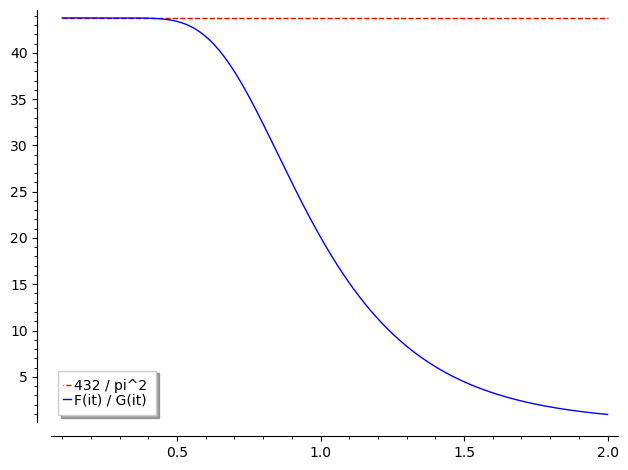

In [31]:
f_24d = qm_to_func(F_24d, prec=50)
g_24d = qm2_to_func(G_24d, prec=100)

q_24d = f_24d / g_24d
lim_24d = 432 / pi^2

p = plot(lim_24d, (t, 0.1, 2.0), color="red", legend_label="432 / pi^2", linestyle="dashed") + \
    plot(q_24d, (t, 0.1, 2.0), color="blue", legend_label="F(it) / G(it)")
show(p)

It is clear from the expression that $G$ is positive. For $F$, the Serre derivative $\partial_{14}F$ of $F$ factors as a product of extremal forms$X_{6,1}$ and $X_{12,1}$, which are both (completely) positive. This implies positivity of $F$.

In [32]:
SF_24d = qm_serre_der_weight(F_24d, 14)
print_qm(SF_24d, "S_14(F_24d)")

X_6_1 = extremal_qm(6, 1)
X_12_1 = extremal_qm(12, 1)
print_qm(X_6_1, "X_6,1")
print_qm(X_12_1, "X_12,1")

assert SF_24d == 6706022400 * X_6_1 * X_12_1

S_14(F_24d)

q_expansion 6706022400*q^3 + 496245657600*q^4 + 14042410905600*q^5 + 216792292147200*q^6 + 2187410622566400*q^7 + 16215323107737600*q^8 + 94873425079910400*q^9 + 460862859379507200*q^10 + 1924860638237644800*q^11 + 7100425841338368000*q^12 + 23586538442064998400*q^13 + 71694366272969932800*q^14 + 201781741465304985600*q^15 + 531331202203774156800*q^16 + 1319004010440990720000*q^17 + 3109234547965516185600*q^18 + 6995462883702112512000*q^19 + O(q^20) 

weight 18
depth 2
cusp order 3
polynomial (-7/3) * (-E2*E4 + E6) * (-12*E2*E4*E6 + 5*E4^3 + 7*E6^2) 

X_6,1

q_expansion q + 18*q^2 + 84*q^3 + 292*q^4 + 630*q^5 + 1512*q^6 + 2408*q^7 + 4680*q^8 + 6813*q^9 + 11340*q^10 + 14652*q^11 + 24528*q^12 + 28574*q^13 + 43344*q^14 + 52920*q^15 + 74896*q^16 + 83538*q^17 + 122634*q^18 + 130340*q^19 + O(q^20) 

weight 6
depth 1
cusp order 1
polynomial (-1/720) * (-E2*E4 + E6) 

X_12,1

q_expansion q^2 + 56*q^3 + 1002*q^4 + 9296*q^5 + 57708*q^6 + 269040*q^7 + 1024532*q^8 + 3321024*q^9 + 9542

Regarding the "hard" inequality, the denominator of the derivative of the fraction is following. It has a single quasimodular factor of weight $14$, depth $2$, and order $3$.

In [33]:
F_24d_ = l1_to_l2(F_24d)
L_24d = qm2_derivative(F_24d_) * G_24d - F_24d_ * qm2_derivative(G_24d)
print_qm2(L_24d, "L_24d")

Fac_24d = (-1) * list(L_24d.factor())[-1][0]  # the last factor including the negative sign
print_qm2(Fac_24d, "Quasimodular factor of L_24d")

L_24d

q_expansion 13424296093286400*qh^11 + 494781198866841600*qh^13 + 4717681198497792000*qh^15 + 1434481925396889600*qh^17 + (-154584605027362406400)*qh^19 + (-391694111409910579200)*qh^21 + 1831396170230503833600*qh^23 + 8236035784021377024000*qh^25 + (-6718846770393749913600)*qh^27 + (-83998612909280408371200)*qh^29 + Order(qh^30) 

weight 32
depth 2
cusp order 11/2
polynomial (-105/8) * H4^2 * (H2 + H4)^2 * H2^5 * (-26*H2^7 - 130*H2^6*H4 - 333*H2^5*H4^2 - 536*H2^4*H4^3 - 415*H2^3*H4^4 - 54*H2^2*H4^5 + 112*H2*H4^6 + 32*H4^7 + 20*H2^6*E2_ + 90*H2^5*H4*E2_ + 96*H2^4*H4^2*E2_ - 52*H2^3*H4^3*E2_ - 186*H2^2*H4^4*E2_ - 192*H2*H4^5*E2_ - 64*H4^6*E2_ + 46*H2^5*E2_^2 + 184*H2^4*H4*E2_^2 + 292*H2^3*H4^2*E2_^2 + 248*H2^2*H4^3*E2_^2 + 80*H2*H4^4*E2_^2 + 32*H4^5*E2_^2) 

Quasimodular factor of L_24d

q_expansion 975421440*qh^6 + 47656304640*qh^8 + 885403975680*qh^10 + 9104305029120*qh^12 + 63040930283520*qh^14 + 332654383595520*qh^16 + 1428831883100160*qh^18 + 5238200413716480*qh^20 + 16888400

We can check that each of the modular components have level $\Gamma_0(2)$, so that we can reduce our search space (and suggests us to use $X_{w, 2}^{(2)}$ and $Y_{w, 2}$).

In [34]:
ls = qm2_components(Fac_24d)
for m in ls:
    assert m2_T_action(m) == m

Now, the factor can be expressed as a positive combination of $X_{w, 2}^{(2)}$, $Y_{w, 2}$ for $w \in \{8, 10, 12\}$, multiplied by suitable powers of $A$ and $B$.

In [35]:
X_8_2_2 = double_level(extremal_qm(8, 2))
X_10_2_2 = double_level(extremal_qm(10, 2))
X_12_2_2 = double_level(extremal_qm(12, 2))
Y_8_2 = Y(8, 2)
Y_10_2 = Y(10, 2)
Y_12_2 = Y(12, 2)

ls = [
    X_8_2_2 * A * B,
    Y_8_2 * A * B,
    X_10_2_2 * A,
    Y_10_2 * A,
    X_12_2_2 * B,
    Y_12_2 * B,
]

x = qm2_find_lin_comb(Fac_24d, ls)
print("Coefficients:", x)

Coefficients: (43027200, 550800, 60963840, 116640, 339075072000, 331776000)
